This code file is the feature based CNN model working directly with the embeddings given by the DAIC-WOZ extended Data Set

### Imports and Setup ###

In this notebook we will:
1. Import helper libraries
2. Define helper functions
3. Configure paths (labels + features)
4. Aggregate OpenFace features per session
5. Train a logistic regression baseline
6. Evaluate on dev/test sets
7. Save results

In [1]:
import os, json, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    brier_score_loss, classification_report, confusion_matrix,
    f1_score, roc_curve, auc, precision_recall_curve
)
from sklearn.calibration import calibration_curve

### Helpers ###

We define small utilities for:
- Seeding
- Normalizing IDs
- Loading labels & features
- Aggregating frames → sessions
- Aligning features with labels
- Metrics calculation
- Threshold selection
- Saving predictions


In [2]:
def set_seed(seed: int = 42):
    import random
    random.seed(seed); np.random.seed(seed)

def normalize_pid(x) -> str:
    try:
        return str(int(float(str(x).strip())))
    except Exception:
        return str(x).strip()

def read_split(labels_dir: str, name: str) -> pd.DataFrame:
    path = os.path.join(labels_dir, f"{name}_split.csv")
    df = pd.read_csv(path)
    df["Participant_ID"] = df["Participant_ID"].apply(normalize_pid)
    df["PHQ_Binary"] = df["PHQ_Binary"].astype(int)
    return df[["Participant_ID", "PHQ_Binary"]]

def read_features_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False)
    df["Participant_ID"] = df["Participant_ID"].apply(normalize_pid)
    return df

def select_numeric(df: pd.DataFrame, drop_cols_like=None) -> pd.DataFrame:
    keep = ["Participant_ID"]
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    cols = keep + [c for c in num if c not in keep]
    out = df[cols].copy()
    if drop_cols_like:
        for patt in drop_cols_like:
            drop_list = [c for c in out.columns if patt.lower() in c.lower()]
            out = out.drop(columns=drop_list)
    return out

def aggregate_to_session(df: pd.DataFrame, agg="mean") -> pd.DataFrame:
    feats = [c for c in df.columns if c != "Participant_ID"]
    df2 = df[["Participant_ID"] + feats].copy()
    for c in feats: df2[c] = pd.to_numeric(df2[c], errors="coerce")
    if agg == "mean":
        return df2.groupby("Participant_ID")[feats].mean()
    elif agg == "meanstd":
        m = df2.groupby("Participant_ID")[feats].mean()
        s = df2.groupby("Participant_ID")[feats].std().add_suffix("_std")
        return pd.concat([m, s], axis=1)
    else:
        raise ValueError("agg must be mean or meanstd")

def align(X_session: pd.DataFrame, labels_df: pd.DataFrame):
    merged = labels_df.merge(
        X_session.reset_index().rename(columns={"index":"Participant_ID"}),
        on="Participant_ID", how="inner"
    )
    ids = merged["Participant_ID"].tolist()
    y = merged["PHQ_Binary"].to_numpy(int)
    X = merged.drop(columns=["Participant_ID","PHQ_Binary"]).to_numpy(float)
    return X, y, ids

def metrics_block(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        "accuracy": accuracy_score(y_true, y_pred),
        "brier": brier_score_loss(y_true, y_prob),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

def choose_threshold(y_true, y_prob, mode="f1"):
    if mode=="none": return 0.5
    if mode=="f1":
        grid = np.linspace(0.05,0.95,19)
        scores = [f1_score(y_true,(y_prob>=t).astype(int),zero_division=0) for t in grid]
        return float(grid[int(np.argmax(scores))])
    if mode=="youden":
        from sklearn.metrics import roc_curve
        fpr,tpr,thr = roc_curve(y_true,y_prob)
        j = tpr-fpr
        return float(thr[np.argmax(j)])
    raise ValueError("mode must be one of none,f1,youden")

def threshold_for_precision(y_true, y_proba, target_prec=0.95):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    thr = np.r_[0.0, thr]
    idx = np.where(prec >= target_prec)[0]
    if len(idx) == 0:
        return None, None, None
    i = idx[np.argmax(rec[idx])]
    return float(thr[i]), float(prec[i]), float(rec[i])

def save_preds(path, ids, y, p, thr):
    df = pd.DataFrame({
        "Participant_ID": ids,
        "label": y,
        "prob_pos": p,
        "pred": (p>=thr).astype(int)
    })
    df.to_csv(path,index=False)


### Config ###


Set dataset paths, aggregation method, threshold strategy, and output directory.

In [3]:
labels_dir = r".\DAIC-WOZ Data\labels"
features_train = r".\DAIC-WOZ Data\processed_data\train_features.csv"
features_dev   = r".\DAIC-WOZ Data\processed_data\dev_features.csv"
features_test  = r".\DAIC-WOZ Data\processed_data\test_features.csv"

agg = "mean"                 # or "meanstd"
optimize_threshold = "f1"    # "none", "f1", "youden"
out_dir = r".\DAIC-WOZ Data\experiments\baseline_openface"
seed = 42
drop_cols_like = []          # e.g. ["frame","timestamp"]

set_seed(seed)
os.makedirs(out_dir, exist_ok=True)


### Load Data ###

Read split files and merged OpenFace feature CSVs. Check class balance.

In [5]:
train_lbl = read_split(labels_dir,"train")
dev_lbl   = read_split(labels_dir,"dev")
test_lbl  = read_split(labels_dir,"test")

f_train = select_numeric(read_features_csv(features_train), drop_cols_like)
f_dev   = select_numeric(read_features_csv(features_dev),   drop_cols_like)
f_test  = select_numeric(read_features_csv(features_test),  drop_cols_like)

for lbls,name in [(train_lbl,"train"),(dev_lbl,"dev"),(test_lbl,"test")]:
    pos = int(lbls["PHQ_Binary"].sum())
    neg = len(lbls)-pos
    print(f"[{name}] n={len(lbls)} pos={pos} neg={neg} rate={pos/len(lbls):.3f}")

[train] n=163 pos=37 neg=126 rate=0.227
[dev] n=56 pos=12 neg=44 rate=0.214
[test] n=56 pos=17 neg=39 rate=0.304


### Aggregate and Align ###

Compute mean (or mean+std) per participant.  Align aggregated features with labels.

In [ ]:
Xs_train = aggregate_to_session(f_train, agg)
Xs_dev   = aggregate_to_session(f_dev, agg)
Xs_test  = aggregate_to_session(f_test, agg)

X_train,y_train,ids_train = align(Xs_train,train_lbl)
X_dev,y_dev,ids_dev       = align(Xs_dev,dev_lbl)
X_test,y_test,ids_test    = align(Xs_test,test_lbl)

X_train.shape, X_dev.shape, X_test.shape

((163, 53), (56, 53), (56, 53))

### Train and Evaluate

We use balanced class weights.  
Threshold is optimized on the dev set.

In [ ]:
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',
        max_iter=2000,
        C=0.01,
        class_weight=None,
        solver='liblinear')
)
clf.fit(X_train,y_train)

y_proba = clf.predict_proba(X_test)[:,1]
p_dev  = clf.predict_proba(X_dev)[:,1]
p_test = clf.predict_proba(X_test)[:,1]

#thr = choose_threshold(y_dev,p_dev,optimize_threshold)
#m_dev = metrics_block(y_dev,p_dev,thr)
#m_test= metrics_block(y_test,p_test,thr)

t, p_at_t, r_at_t = threshold_for_precision(y_test, y_proba, target_prec=0.95)
if t is None:
    print("No thres possible")
else:
    print(f"t={t:.3f} -> precision={p_at_t:.3f}, recall={r_at_t:.3f}")
    y_pred = (y_proba >= t).astype(int)

#print(f"=== Threshold ({optimize_threshold}) -> {thr:.3f}")
#print("DEV:",m_dev)
#print("TEST:",m_test)

print("\n=== DEV REPORT ===")
print(classification_report(y_dev,(p_dev>=thr).astype(int),digits=3,zero_division=0))
print("Confusion:\n",confusion_matrix(y_dev,(p_dev>=thr).astype(int)))

print("\n=== TEST REPORT ===")
print(classification_report(y_test,(p_test>=thr).astype(int),digits=3,zero_division=0))
print("Confusion:\n",confusion_matrix(y_test,(p_test>=thr).astype(int)))

t=0.517 -> precision=1.000, recall=0.059
=== Threshold (f1) -> 0.350
DEV: {'roc_auc': 0.4867424242424242, 'pr_auc': 0.22475302452651855, 'accuracy': 0.35714285714285715, 'brier': 0.2208880016001639, 'f1': 0.35714285714285715}
TEST: {'roc_auc': 0.5686274509803921, 'pr_auc': 0.43323471433533334, 'accuracy': 0.35714285714285715, 'brier': 0.22021943929365811, 'f1': 0.45454545454545453}

=== DEV REPORT ===
              precision    recall  f1-score   support

           0      0.833     0.227     0.357        44
           1      0.227     0.833     0.357        12

    accuracy                          0.357        56
   macro avg      0.530     0.530     0.357        56
weighted avg      0.703     0.357     0.357        56

Confusion:
 [[10 34]
 [ 2 10]]

=== TEST REPORT ===
              precision    recall  f1-score   support

           0      0.714     0.128     0.217        39
           1      0.306     0.882     0.455        17

    accuracy                          0.357        5

In [41]:

#prec, rec, thr = precision_recall_curve(y_test, p_dev)

#for p, r, t in zip(prec[::10], rec[::10], thr[::10]):
#    print(f"Threshold {t:.2f}: Precision={p:.2f}, Recall={r:.2f}")

#target_prec = 0.6
#idx = np.where(prec >= target_prec)[0][0]
#best_thr = thr[idx]
#print(f"Chosen threshold: {best_thr:.3f}")

#y_test = (p_dev >= best_thr).astype(int)

### Save Outputs

We persist:
- Pickled classifier
- CSVs with predictions
- JSON with metadata & metrics

In [65]:
with open(os.path.join(out_dir,"baseline_logreg.pkl"),"wb") as f:
    pickle.dump(clf,f)

save_preds(os.path.join(out_dir,"dev_predictions.csv"),ids_dev,y_dev,p_dev,thr)
save_preds(os.path.join(out_dir,"test_predictions.csv"),ids_test,y_test,p_test,thr)

meta = {
    "agg": agg,
    "optimize_threshold": optimize_threshold,
    "threshold": float(thr),
    "labels_dir": labels_dir,
    "features_train": features_train,
    "features_dev": features_dev,
    "features_test": features_test,
    "drop_cols_like": drop_cols_like,
    "metrics_dev": m_dev,
    "metrics_test": m_test,
    "seed": seed
}
with open(os.path.join(out_dir,"run_meta.json"),"w") as f:
    json.dump(meta,f,indent=2)

print(f"[ok] Saved artifacts to {out_dir}")

[ok] Saved artifacts to .\DAIC-WOZ Data\experiments\baseline_openface


### Visual Aids

We’ll generate:
1. ROC curves (Dev & Test)
2. Precision–Recall curves (Dev & Test)
3. Calibration (reliability) curves
4. Confusion matrices at the chosen threshold
5. (Optional) Top logistic-regression coefficients

All figures will also be saved into `out_dir` as PNG files.

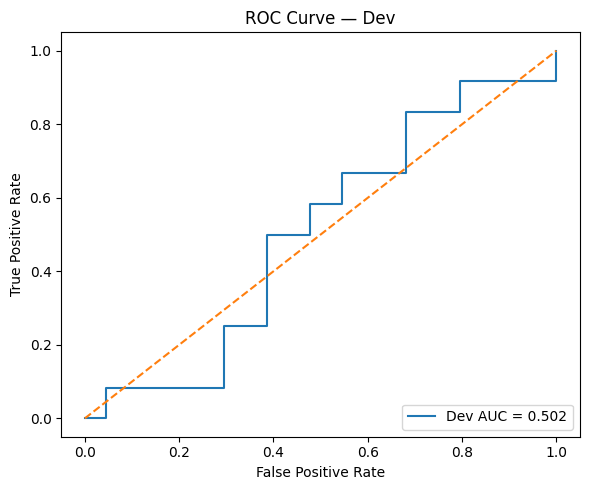

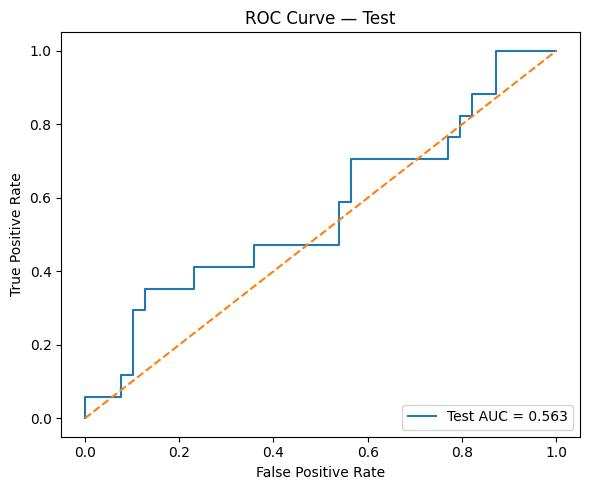

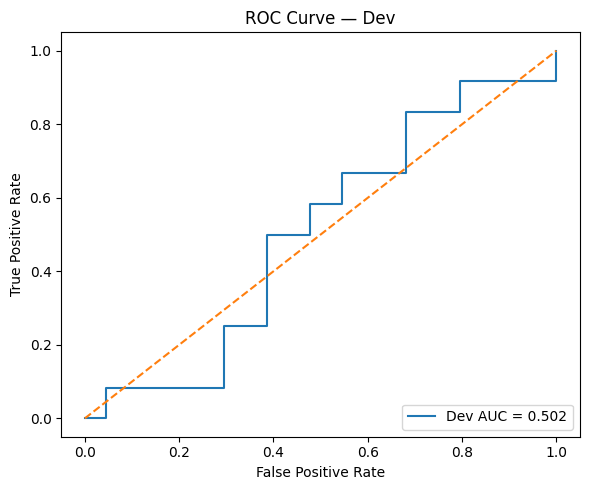

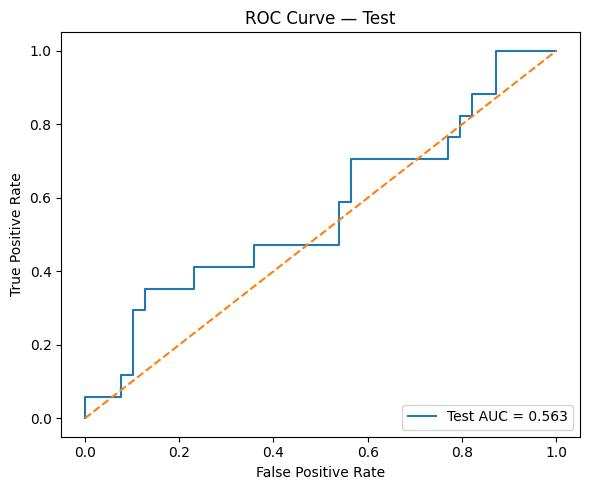

In [66]:
# --- DEV ROC ---
fpr_d, tpr_d, _ = roc_curve(y_dev, p_dev)
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(6,5))
plt.plot(fpr_d, tpr_d, label=f"Dev AUC = {auc_d:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Dev")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
fpr_t, tpr_t, _ = roc_curve(y_test, p_test)
auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label=f"Test AUC = {auc_t:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Save
plt.figure(figsize=(6,5))
plt.plot(fpr_d, tpr_d, label=f"Dev AUC = {auc_d:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Dev"); plt.legend(loc="lower right"); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "roc_dev.png"))

plt.figure(figsize=(6,5))
plt.plot(fpr_t, tpr_t, label=f"Test AUC = {auc_t:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Test"); plt.legend(loc="lower right"); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "roc_test.png"))

#### 2. Precision Recall Curves

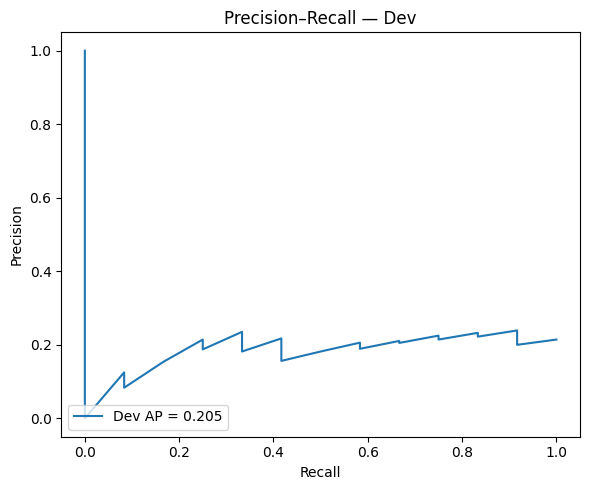

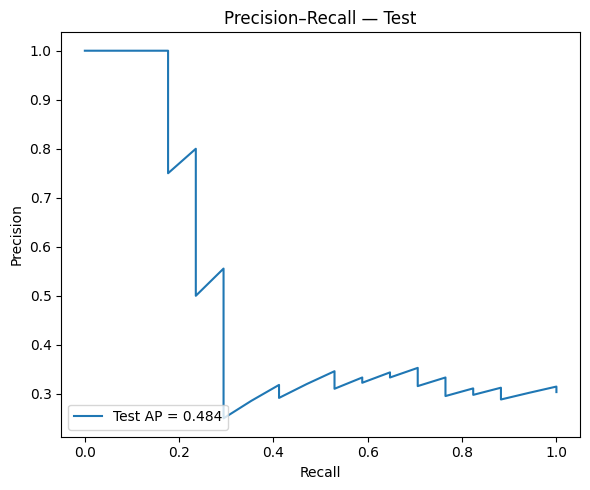

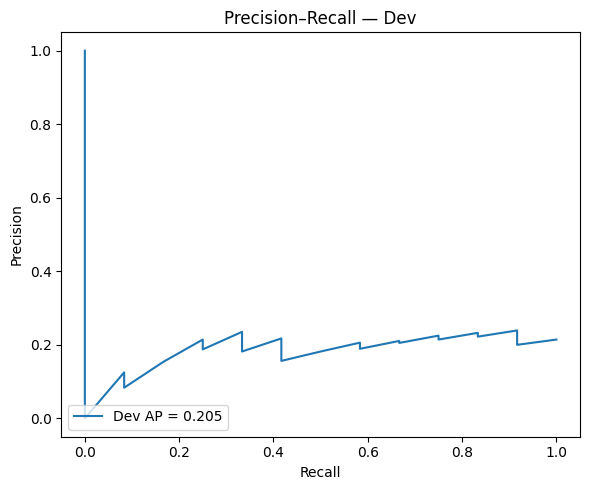

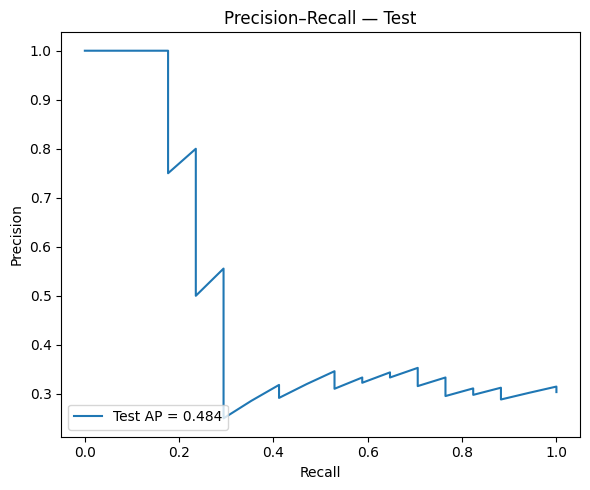

In [9]:
prec_d, rec_d, _ = precision_recall_curve(y_dev, p_dev)
ap_d = average_precision_score(y_dev, p_dev)

plt.figure(figsize=(6,5))
plt.plot(rec_d, prec_d, label=f"Dev AP = {ap_d:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall — Dev")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

prec_t, rec_t, _ = precision_recall_curve(y_test, p_test)
ap_t = average_precision_score(y_test, p_test)

plt.figure(figsize=(6,5))
plt.plot(rec_t, prec_t, label=f"Test AP = {ap_t:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall — Test")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Save
plt.figure(figsize=(6,5))
plt.plot(rec_d, prec_d, label=f"Dev AP = {ap_d:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — Dev"); plt.legend(loc="lower left"); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pr_dev.png"))

plt.figure(figsize=(6,5))
plt.plot(rec_t, prec_t, label=f"Test AP = {ap_t:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — Test"); plt.legend(loc="lower left"); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pr_test.png"))

#### 3. Calibration (Reliability) Curves

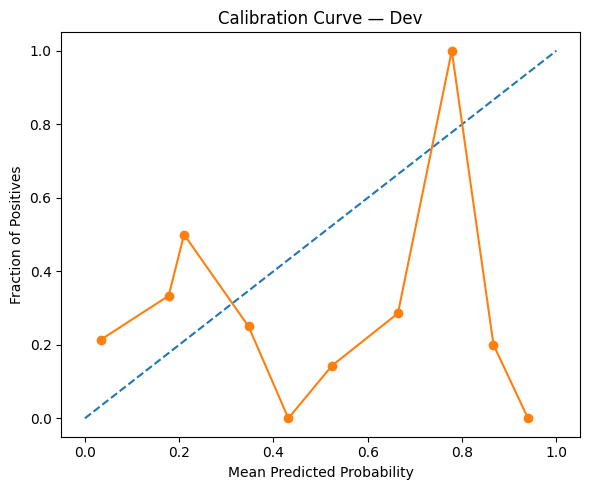

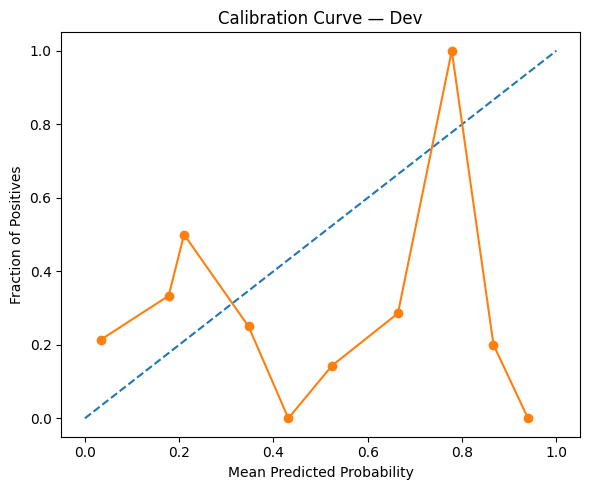

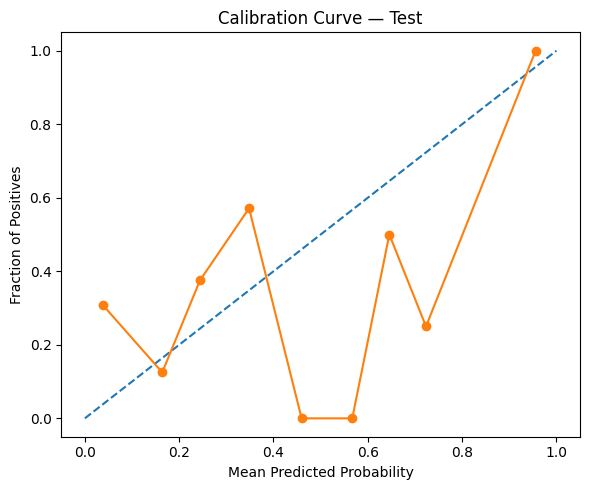

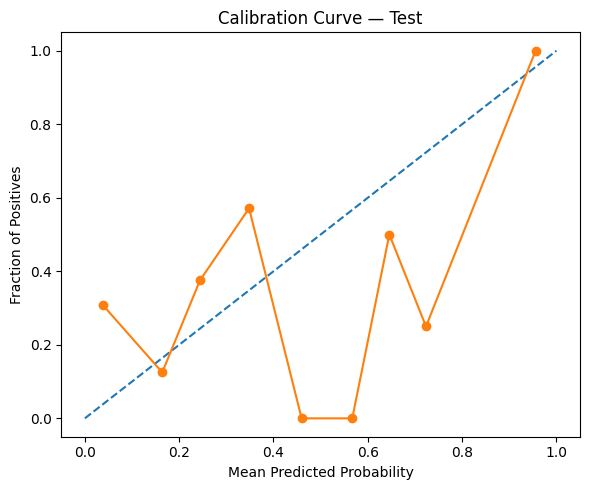

In [10]:
def plot_calibration(y_true, y_prob, title, save_name):
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.figure(figsize=(6,5))
    plt.plot([0,1], [0,1], linestyle="--")
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot([0,1], [0,1], linestyle="--")
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.xlabel("Mean Predicted Probability"); plt.ylabel("Fraction of Positives")
    plt.title(title); plt.tight_layout()
    plt.savefig(os.path.join(out_dir, save_name))

plot_calibration(y_dev, p_dev,  "Calibration Curve — Dev",  "calibration_dev.png")
plot_calibration(y_test, p_test,"Calibration Curve — Test","calibration_test.png")

#### Confusion Matrices at Threshold

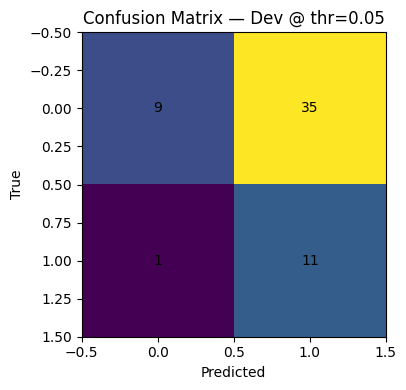

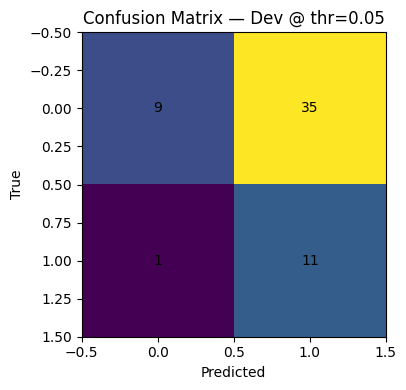

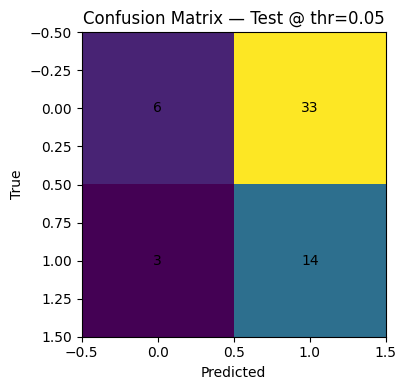

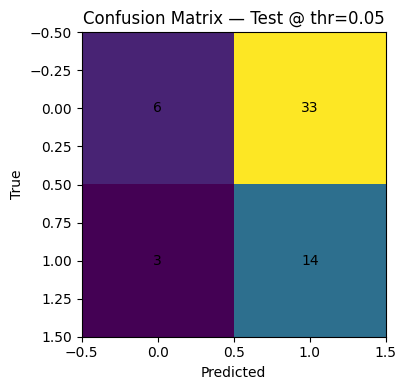

In [11]:
def plot_conf_mat(y_true, y_prob, thr, title, save_name):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    # Annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4.5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, save_name))

plot_conf_mat(y_dev,  p_dev,  thr, f"Confusion Matrix — Dev @ thr={thr:.2f}",  "cm_dev.png")
plot_conf_mat(y_test, p_test, thr, f"Confusion Matrix — Test @ thr={thr:.2f}", "cm_test.png")

#### Top Coefficients

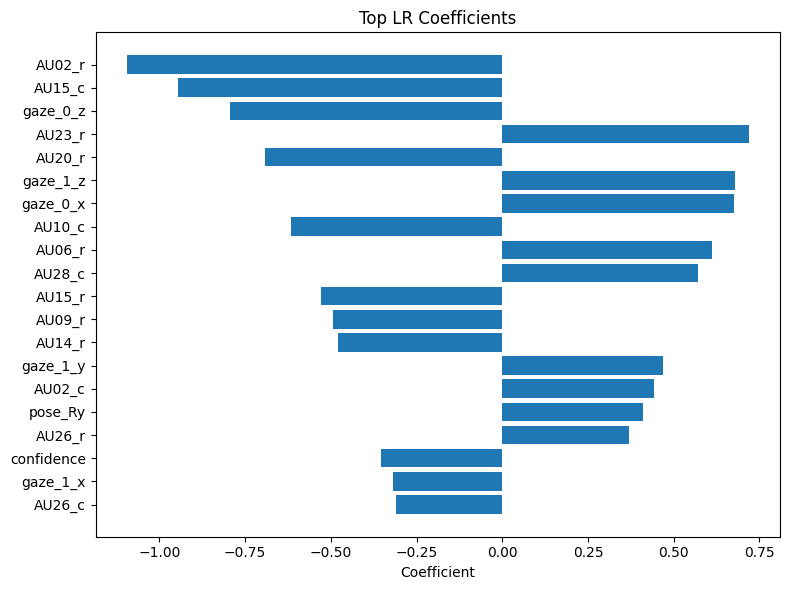

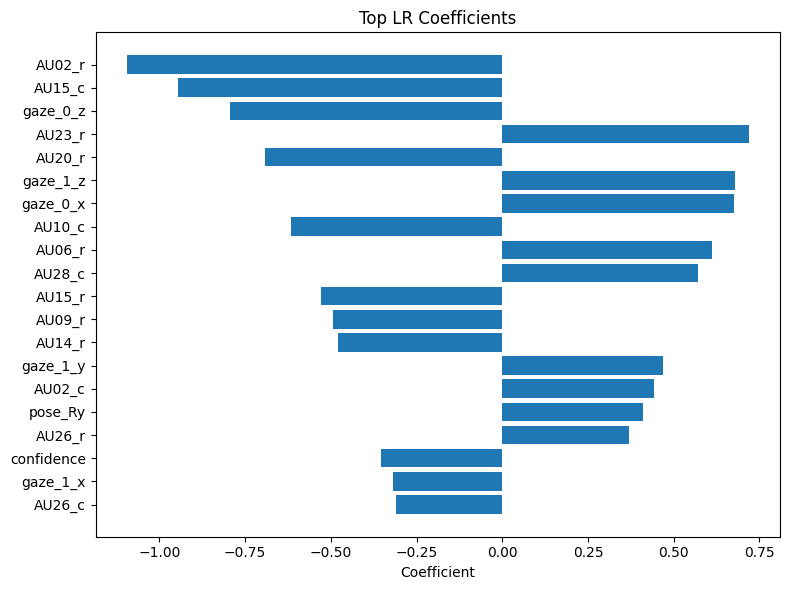

In [12]:
# Only works if the pipeline is [StandardScaler, LogisticRegression]
logreg = clf.named_steps["logisticregression"]
coef = logreg.coef_.ravel()

# Recover feature names from the aggregated training frame
feature_names = list(Xs_train.columns)

# Sort by absolute magnitude
idx_sorted = np.argsort(np.abs(coef))[::-1]
top_k = 20  # change as you like

top_idx = idx_sorted[:top_k]
top_feats = [feature_names[i] for i in top_idx]
top_vals  = coef[top_idx]

plt.figure(figsize=(8, max(4, 0.3*top_k)))
ypos = np.arange(len(top_feats))
plt.barh(ypos, top_vals)
plt.yticks(ypos, top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient")
plt.title("Top LR Coefficients")
plt.tight_layout()
plt.show()

# Save
plt.figure(figsize=(8, max(4, 0.3*top_k)))
ypos = np.arange(len(top_feats))
plt.barh(ypos, top_vals)
plt.yticks(ypos, top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient"); plt.title("Top LR Coefficients"); plt.tight_layout()
plt.savefig(os.path.join(out_dir, "top_coefficients.png"))